In [1]:
import pandas as pd
import numpy as np
import os
import re
import datetime as dt
import calendar

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.io as pio
pyo.init_notebook_mode(connected=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.optimize import minimize
import scipy.stats as scs

from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
if not os.path.exists('graphiques'):
    os.mkdir('graphiques')

In [3]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)

In [4]:
!ls './data/eCO2'

eCO2mix_RTE_Annuel-Definitif_2012.csv  eCO2mix_RTE_Annuel-Definitif_2015.csv
eCO2mix_RTE_Annuel-Definitif_2013.csv  eCO2mix_RTE_Annuel-Definitif_2016.csv
eCO2mix_RTE_Annuel-Definitif_2014.csv  eCO2mix_RTE_Annuel-Definitif_2017.csv


### <font color='blue'>Merging dataframe from files<font>

In [ ]:
df_raw = pd.DataFrame()
tot_length=0
for file in os.listdir('data/eCO2'):
    df_to_merge=pd.read_csv('./data/eCO2/{}'.format(file), low_memory=False)#set low_memory=False to ignore mixed type in columns (handled later)
    length = len(df_to_merge)
    print(length)
    tot_length +=length
    df_raw = df_raw.append(df_to_merge)
print(tot_length)
df_raw=df_raw.reset_index(drop=True)
display(df_raw.head(2))

35136
35040
35136
35040
35040
35040
210432


,Perimetre,Nature,Date,Heures,Consommation,Prevision J-1,Prevision J,Fioul,Charbon,Gaz,Nucleaire,Eolien,Solaire,Hydraulique,Pompage,Bioenergies,Ech. physiques,Taux de Co2,Ech. comm. Angleterre,Ech. comm. Espagne,Ech. comm. Italie,Ech. comm. Suisse,Ech. comm. Allemagne-Belgique,Fioul - TAC,Fioul - Cogen.,Fioul - Autres,Gaz - TAC,Gaz - Cogen.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + eclusee,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioenergies - Dechets,Bioenergies - Biomasse,Bioenergies - Biogaz
0,France,Donnees definitives,2012-01-01,00:00,58315.0,58200,58200,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0,-9806.0,33.0,-1750,-1200,-862,-2625,-2940,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
1,France,Donnees definitives,2012-01-01,00:15,NaN,57700,57550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color='blue'>Files (each year) don't have the same number of record of electricity consumption, and some NaN data appear<font>

In [ ]:
df_eCO2=df_raw.iloc[:,0:7].copy()
display(df_eCO2.head(2))

,Perimetre,Nature,Date,Heures,Consommation,Prevision J-1,Prevision J
0,France,Donnees definitives,2012-01-01,00:00,58315.0,58200,58200
1,France,Donnees definitives,2012-01-01,00:15,NaN,57700,57550


In [ ]:
df_eCO2['Date']=df_eCO2['Date'].astype('datetime64[ns]')
df_eCO2=df_eCO2.sort_values(by=['Date','Heures'],ascending=True)

In [ ]:
#column full datetime (sec)
df_eCO2['Datetime'] = pd.to_datetime(df_eCO2['Date'].apply(str)+' '+df_eCO2['Heures'])
df_eCO2['Datetime']=df_eCO2['Datetime'].astype('datetime64[ns]')
df_eCO2.head(2)

In [ ]:
data=df_eCO2.dropna().copy()
print(len(data))

x=data['Datetime']
y1=data['Consommation']


trace1 = go.Scatter(
    x=x,
    y=y1,
    name = "Consommation",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

layout = dict(
    title=dict(text="<b>Consommation électrique<b>",
                   font=dict(family='Linux Biolinum O',size=18,color='black')),
    xaxis=dict(title='Datum',
        rangeselector=dict(
            buttons=list([
                dict(count=7,
                     label='7d',
                     step='day',
                     stepmode='backward'),
                dict(count=3,
                     label='3m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'),
    yaxis=dict(title='KW/H')
)

data = [trace1]

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)

La  variance  ne  semble  pas  toujours  constante autour  de  la  moyenne  saisonnière à  court  terme  mais  elle reste  relativement  stable  sur  des  périodes  plus  longues. 

### Comsumption have a year, week and a year cycle. Called seasonalities

### Also, summer afternoon and winter afternoon are very differents

In [ ]:
def add_datepart(df, fldname, drop=False, time=False):
    
    import re
    
    "Add columns relevant to a date in the column `fldname` of `df`."
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]atetime$', '', fldname)
    #attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            #'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    attr=['Year', 'Month', 'Week', 'Day']
    if time: attr = attr + ['Hour', 'Minute', 'Second', 'Dayofweek']
    
    '''à tester:
    -sans la ligne suivante pour enlever cette colonne,
    -et de façon isoler pour la corriger'''
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

add_datepart(df_eCO2,'Datetime',time=True)
df_eCO2.head(2)

### <font color='blue'>NaN Data?<font>

In [ ]:
len(df_eCO2)

In [ ]:
pd.DataFrame(df_eCO2.isna().sum()).T

In [ ]:
#NaN time minutes localisation
for quarter in df_eCO2['Minute'].unique():
    df=df_eCO2[df_eCO2['Minute']==quarter]
    df=pd.DataFrame(df.isna().sum()).T
    count=int(df['Consommation'][0])
    print(quarter,':',count)

In [ ]:
df_eCO2.loc[df_eCO2['Consommation'].isnull()].head(2)

### <font color='red'>Every xx:15 and xx:45 records in 'Consomation' are NaN<font>  
### <font color='green'>For now, i consider this data are not necessary but to be removed to ligth data. We could eventually estimate them by refering to previsions and consommation.<font>  

In [ ]:
df_eCO2=df_eCO2.dropna()

### <font color='red'>In cell n°5 (merging), noted that 2 Dataframes are longer than other. More preciasily:<font>

In [ ]:
#localisation
for year in df_eCO2['Year'].unique():
    df=df_eCO2[df_eCO2['Year']==year]
    l=len(df)
    print(year,':',l)

In [ ]:
#days 17520 
(17568-17520)/2/24#because data have 30 mins frequency.

##### <font color='green'>one day is recorded in 2012 and 2016, but not in 2013,2015,2016,2017
#### <font color='red'>Wich days are missing?
##### <font color='green'>Pbly in february<font>

In [ ]:
#localisation
for year in df_eCO2['Year'].unique():
    df=df_eCO2[(df_eCO2['Year']==year)&(df_eCO2['Month']==2.0)]
    l=int(len(df))/48
    print(year,':',l)

In [ ]:
for year in df_eCO2['Year'].unique():
    df = df_eCO2[(df_eCO2['Year']==year)&(df_eCO2['Month']==2.0)&
                (df_eCO2['Day']==29.0)]
    display(df.head(1))

### <font color='green'>That's it: years bisextile and not<font>

### <font color='red'>The fact that  2012 and 2016 has one day more can be a source of problems. A specialy for prediction and machine learning<font>

In [ ]:
data=df_eCO2.copy()
N = df_eCO2['Dayofweek'].unique()     # boxes (dayofweek)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(N))]#color generator
# Each box is represented by a dict that contains the data, the type, and the colour. 
data = [{
    'y': data['Consommation'][data['Dayofweek']==m], 
    'name':str(calendar.day_name[m]),
    'type':'box',
    'marker':{'color': c[m-1]}
    } for m in np.arange(0,len(N),1)]

layout = go.Layout(title=dict(text="<b>Consommation hebdomadaire<b>",
                   font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Dayofweek',showgrid=False,zeroline=False, tickangle=-45,showticklabels=True),
                   yaxis=dict(title='Consommation',gridcolor='white', zeroline=False),
                   paper_bgcolor='rgb(233,233,233)',
                   plot_bgcolor='rgb(233,233,233)',
                  )

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)


In [ ]:
data=df_eCO2.copy()
N = df_eCO2['Month'].unique()     # boxes (months)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(N))]#color generator
# Each box is represented by a dict that contains the data, the type, and the colour. 
data = [{
    'y': data['Consommation'][data['Month']==m], 
    'name':str(calendar.month_name[m]),
    'type':'box',
    'marker':{'color': c[m-1]}
    } for m in np.arange(0,len(N)+1,1)]

layout = go.Layout(title=dict(text="<b>Consommation mensuelle<b>",
                   font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Months',showgrid=False,zeroline=False, tickangle=-45,showticklabels=True),
                   yaxis=dict(title='Consommation',gridcolor='white', zeroline=False),
                   paper_bgcolor='rgb(233,233,233)',
                   plot_bgcolor='rgb(233,233,233)',
                  )

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)


In [ ]:
data=df_eCO2.copy()
N = df_eCO2['Year'].unique()     # boxes (years)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(N))]#color generator
# Each box is represented by a dict that contains the data, the type, and the colour. 
data = [{
    'y': data['Consommation'][data['Year']==m], 
    'name':str(m),
    'type':'box',
    'marker':{'color': c[m-2012-1]}
    } for m in list(N)]

layout = go.Layout(title=dict(text="<b>Consommation annuelle<b>",
                   font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Year',showgrid=False,zeroline=False, tickangle=-45,showticklabels=True),
                   yaxis=dict(title='Consommation',gridcolor='white', zeroline=False),
                   paper_bgcolor='rgb(233,233,233)',
                   plot_bgcolor='rgb(233,233,233)',
                  )

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)


In [ ]:
df_eCO2.columns

In [ ]:
data=df_eCO2.copy()
years = list(data['Year'].unique())

x=data['Datetime']
y1=data['Consommation']
y2=data['Prevision J-1']
y3=data['Prevision J']


trace1 = go.Line(x=x,
                  y=y1,
                  opacity = 1,
                  name='Consommation',
                  marker=dict(color='green'))

trace2 = go.Line(x=x,
                  y=y2,
                  opacity = 0.6,
                  name='Prevision J-1',
                  marker=dict(color='blue'))

trace3 = go.Line(x=x,
                  y=y3,
                  opacity = 0.6,
                  name='Prevision J',
                  marker=dict(color='red'))

data = [trace1,trace2,trace3]

layout = dict(
    title=dict(text="<b>Consommation et prédictions<b>",
               font=dict(family='Linux Biolinum O',size=18,color='black')),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
pyo.iplot(fig)

In [ ]:
data=df_eCO2.copy()

print(len(data))

x=data['Datetime']
y1=data['Consommation']-data['Prevision J-1']
y2=data['Consommation']-data['Prevision J']


trace1 = go.Line(x=x,
                  y=y1,
                  name='Consommation-prévision J-1',
                  marker=dict(color='red'))

trace2 = go.Line(x=x,
                  y=y2,
                  name='Consommation-prévision J',
                  marker=dict(color='blue'))

data = [trace1,trace2]

layout = go.Layout(title=dict(text="<b><b>",
                              font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Datum'),
                   yaxis=dict(title=''))

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)


In [ ]:
print('Prevision J',df_eCO2['Month'][df_eCO2['Prevision J']==0].unique())
print('Prevision J',df_eCO2['Year'][df_eCO2['Prevision J']==0].unique())
print('Prevision J-1',df_eCO2['Month'][df_eCO2['Prevision J-1']==0].unique())
print('Prevision J-1',df_eCO2['Year'][df_eCO2['Prevision J-1']==0].unique())

In [ ]:
df_eCO2['Prevision J'][df_eCO2['Prevision J']==0].count()

### <font color='red'>94 forecasts ('Prevision J') for the month of March 2015 are inconsistent. It is opportune, considering the prediction purpose, to correct this by referring to the predictions of March of other years. <font>

In [ ]:
df_eCO2.head(2)

In [ ]:
#isolate datetime if predicition is <0 then list day and month
#and return mean prediction from other years, at the same time
list_mean=[]
list_datetime_no_prediction=list(df_eCO2['Datetime'][df_eCO2['Prevision J']==0])
#extract day month and time
for dt in list_datetime_no_prediction:
    day=int(df_eCO2.Day[df_eCO2['Datetime']==dt].values)
    month=int(df_eCO2.Month[df_eCO2['Datetime']==dt].values)
    tim=str(df_eCO2.Heures[df_eCO2['Datetime']==dt].values)
    tim=tim[2:7]
    i = int(df_eCO2.index[df_eCO2['Datetime']==dt].values)
    mean = df_eCO2['Prevision J'][(df_eCO2['Year'].isin(['2012','2013','2014','2016','2017']))&
                 (df_eCO2['Day']==day)&
                 (df_eCO2['Month']==month)&
                 (df_eCO2['Heures']==tim)
                  ].mean()
    df_eCO2.at[i,'Prevision J']=mean

In [ ]:
df_eCO2['Prevision J'][df_eCO2['Prevision J']==0].count()

In [ ]:
from random import randint

In [ ]:

data=df_eCO2.dropna().reset_index(drop=True)
rec_day = len(df_eCO2)/len(df_eCO2['Date'].unique())
week_i = 7*rec_day#week interval
r = randint(a=week_i,b=len(data)-week_i)
years = list(data['Year'].unique())
data = data[['Date','Datetime','Heures','Consommation','Prevision J-1','Prevision J']].loc[r-week_i/2:r+week_i/2,:]

x=data['Datetime']
y1=data['Consommation']
y2=data['Prevision J-1']
y3=data['Prevision J']


trace1 = go.Line(x=x,
                  y=y1,
                  opacity = 1,
                  name='Consommation',
                  marker=dict(color='green'))

trace2 = go.Line(x=x,
                  y=y2,
                  opacity = 0.6,
                  name='Prevision J-1',
                  marker=dict(color='blue'))

trace3 = go.Line(x=x,
                  y=y3,
                  opacity = 0.6,
                  name='Prevision J',
                  marker=dict(color='red'))

data = [trace1,trace2,trace3]

layout = dict(
    title=dict(text="<b>Consommation et prédictions, échelles plus fines & période aléatoire<b>",
               font=dict(family='Linux Biolinum O',size=18,color='black')),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1d',
                     step='day',
                     stepmode='backward'),
                dict(count=7,
                     label='7d',
                     step='day',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
pyo.iplot(fig)

In [ ]:
### seasons
data=df_eCO2.dropna().reset_index(drop=True)
data=data.groupby(by=['Month','Day','Heures'], as_index=False).mean()
x=data['Heures'].unique()
summer=data['Consommation'][(data['Day']==15)&(data['Month']==7)]
spring=data['Consommation'][(data['Day']==15)&(data['Month']==4)]
fall=data['Consommation'][(data['Day']==30)&(data['Month']==10)]
winter=data['Consommation'][(data['Day']==1)&(data['Month']==1)]

trace1 = go.Line(x=x,
                  y=summer,
                  opacity = 1,
                  name='Ete 15-07',
                  marker=dict(color='red'))

trace2 = go.Line(x=x,
                  y=spring,
                  opacity = 0.6,
                  name='Printemps 15-04',
                  marker=dict(color='green'))

trace3 = go.Line(x=x,
                  y=fall,
                  opacity = 0.6,
                  name='Automne 30-10',
                  marker=dict(color='black'))

trace4 = go.Line(x=x,
                  y=winter,
                  opacity = 0.6,
                  name='Hiver 01-01',
                  marker=dict(color='blue'))

data = [trace1,trace2,trace3,trace4]

layout = go.Layout(title=dict(text="<b>Consommation sur 24h selon la saison<b>",
                              font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Datum'),
                   yaxis=dict(title='KW/H'))

fig = dict(data=data, layout=layout)
pyo.iplot(fig)

### Daylike has some specificities (daymean and evening) regarding to the season but general rythmus is almost the same:  
Consommation raises arround 5 am until noon, then drops (more or less) during after-noon, reraise arround 17:30 and appears some specificities during the evening, finally drops until morning.

Week and season point of view

In [ ]:
### week seasons
data=df_eCO2.dropna().reset_index(drop=True)
data=data.groupby(by=['Month','Dayofweek','Heures'], as_index=False).mean()

x=[]
hours=df_eCO2['Heures'].unique()
daysweeks=[calendar.day_name[m] for m in np.arange(0,7,1)]
for d in daysweeks:
    for h in hours:
        dh=str(d+' '+h)
        x.append(dh)
        
summer=data['Consommation'][data['Month']==7]
spring=data['Consommation'][data['Month']==4]
fall=data['Consommation'][data['Month']==10]
winter=data['Consommation'][data['Month']==1]

trace1 = go.Line(x=x,
                  y=summer,
                  opacity = 1,
                  name='July',
                  marker=dict(color='red'))

trace2 = go.Line(x=x,
                  y=spring,
                  opacity = 0.6,
                  name='April',
                  marker=dict(color='green'))

trace3 = go.Line(x=x,
                  y=fall,
                  opacity = 0.8,
                  name='October',
                  marker=dict(color='black'))

trace4 = go.Line(x=x,
                  y=winter,
                  opacity = 0.6,
                  name='January',
                  marker=dict(color='blue'))

data = [trace1,trace2,trace3,trace4]

layout = go.Layout(title=dict(text="<b>Consommation sur une semaine selon la saison<b>",
                              font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Datum',
                              type='-',
                              nticks = 7,
                              autorange=True),
                   yaxis=dict(title='KW/H'))

fig = dict(data=data, layout=layout)
pyo.iplot(fig)

### <font color='red'>Weekday and Week-end seems different whatever the season

Datetime has been lost in the battel

In [ ]:
df_eCO2['Datetime'] = pd.to_datetime(df_eCO2['Date'].apply(str)+' '+df_eCO2['Heures'])
df_eCO2['Datetime']=df_eCO2['Datetime'].astype('datetime64[ns]')
df_eCO2.head(2)

# <font color='orange'>Heat correction of the consumption data<font>
#### DJU are localy and monthly recorded. So we'll focus on NICE
The heat fixing consists of removing the extr, whatever the harshness of the winter. By reducing the heating consumption to a reference climate, characterized by the DJU, it removes the variations due to the climatic severity. Kind of outlier removal.  
formula:  
Cconsumption = consumption x (DJU_reference/DJU_day)  
    with:  
    DJU_reference = 18  
          DJU_day = download  
          consumption = download
    

In [ ]:
df_raw=pd.read_csv('./data/dju_nice.csv')
display(df_raw.head(2))

### <font color='blue'>Preparing for merging<font>

In [ ]:
l_months=list(df_raw.columns.unique()[1:13])
l_years = list(df_raw['Annee'].unique())

In [ ]:
df_DJU=pd.DataFrame()
df_DJU['Year']=np.repeat(l_years,len(l_months))
df_DJU['Month_l']=np.tile(l_months,len(l_years))
df_DJU['Month']=np.tile(np.arange(1,13,1),len(l_years))
df_DJU.head(2)

In [ ]:
from itertools import product

l_djus=[]
for y,m in product(l_years,l_months):
    df = df_raw[df_raw['Annee']==y].copy()
    dju = float(df[[m]].values)
    l_djus.append(dju)

In [ ]:
df_DJU['dju']=l_djus

In [ ]:
df_DJU.head(2)

In [ ]:
data=df_DJU.copy()
data = data.groupby(by=['Year','Month_l'],as_index=False).mean()
data = data.sort_values(by=['Year','Month'])

liste_m_y=[]
for y in l_years:
    for m in l_months:
        d = str(y) + str(m)
        liste_m_y.append(d)

x=liste_m_y
y1=data['dju']
trace1 = go.Line(x=x,
                  y=y1,
                  name='DJU mensuel',
                  marker=dict(color='red'))

data = [trace1]

layout = go.Layout(title=dict(text="<b>Nice 2012--2018 (1)<b>",
                              font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Datum'),
                   yaxis=dict(title='DJU', ),
                   paper_bgcolor='rgb(233,233,233)',
                   plot_bgcolor='rgb(233,233,233)',)

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)

In [ ]:
data=df_DJU.copy()
data = data.groupby(by=['Year','Month'],as_index=False).mean()
data = data.sort_values(by=['Year','Month'])
N = df_eCO2['Month'].unique()     # boxes (months)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(N))]#color generator
# Each box is represented by a dict that contains the data, the type, and the colour. 
data = [{
    'y': data['dju'][data['Month']==m], 
    'name':str(calendar.month_name[m]),
    'type':'box',
    'marker':{'color': c[m-1]}
    } for m in np.arange(1,len(N)+1,1)]

layout = go.Layout(title=dict(text="<b>DJU Nice 2012--2018 (2)<b>",
                   font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Months',showgrid=False,zeroline=False, tickangle=-45,showticklabels=True),
                   yaxis=dict(title='DJU',gridcolor='white', zeroline=False),
                   paper_bgcolor='rgb(233,233,233)',
                   plot_bgcolor='rgb(233,233,233)',
                  )

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)


In [ ]:
df_p9 = df_eCO2.merge(df_DJU, on=['Month','Year'])
df_p9.head(2)

In [ ]:
data=df_p9.copy()
data = data.groupby(by=['Year','Month'],as_index=False).mean()
data = data.sort_values(by=['Year','Month'])
data=data.reset_index(drop=True)
print(len(data))

x=liste_m_y
y1=data['Consommation']
y2=data['dju']


trace1 = go.Line(x=x,
                  y=y1,
                  opacity = 0.8,
                  name='Consommation',
                  marker=dict(color='green'))

trace2 = go.Line(x=x,
                  y=y2,
                  opacity = 0.8,
                  name='DJU',
                  marker=dict(color='red'),
                  yaxis='y2')

data = [trace1,trace2]

layout = go.Layout(title=dict(text="<b>Concordance entre la consommation électrique mensuelle et les DJU<b>",
                              font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Datum'),
                   yaxis=dict(title='KW/h'),
                   yaxis2=dict(
                            title='dju',
                            titlefont=dict(
                                color='rgb(148, 103, 189)'
                            ),
                            tickfont=dict(
                                color='rgb(148, 103, 189)'
                            ),
                            overlaying='y',
                            side='right'),
                   paper_bgcolor='rgb(233,233,233)',
                   plot_bgcolor='rgb(233,233,233)',
                  )


fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)


### <font color='violet'>Heat correction via linear regression<font>

### Linear correction will pbly year deseasonal the consommation no?

In [ ]:
reg_lin = smf.ols(formula='Consommation ~ dju', data=df_p9).fit()
reg_lin.summary()

### R² is, as expected, pretty high: dju and consommation look correlated:  
###  Despite the difference of accuracy between DJU and Consumption data, the DJUs variation is about 3/4 of the consumption variation. The correction could be more accurate if the DJUs had a dayly accuracy for example.
### Coeff is relevant refering to the interval confidence and the t test.

In [51]:
reg_lin.params

Intercept    45075.531899
dju             97.466424
dtype: float64

In [52]:
reg_lin.params['dju']

97.466423937384008

In [53]:
df_p9_first_correction=df_p9.copy()
df_p9_first_correction.loc[:,'Residuals'] = reg_lin.resid
df_p9_first_correction.loc[:,'dju*coeff']=df_p9_first_correction.loc[:,'dju']*reg_lin.params['dju']
df_p9_first_correction['Correction_consommation'] = df_p9_first_correction.loc[:,'Consommation']-df_p9_first_correction.loc[:,'dju*coeff']

print(len(df_p9_first_correction))
df_p9_first_correction=df_p9_first_correction.reset_index(drop=True)
df_p9_first_correction.head(2)


2192


,Date,Consommation,Prevision J-1,Prevision J,Year,Month,Week,Day,Dayofweek,Datetime,Month_l,dju,Residuals,dju*coeff,Correction_consommation
0,2012-01-01,51491.500000,51085.416667,50452.083333,2012.0,1.0,52.0,1.0,6.0,2012-01-01,Jan,248.3,-17784.944963,24200.913064,27290.586936
1,2012-01-02,60683.645833,60331.250000,59735.416667,2012.0,1.0,1.0,2.0,0.0,2012-01-02,Jan,248.3,-8592.799129,24200.913064,36482.732770


In [54]:
data=df_p9_first_correction.copy()
print(len(data))

x=data['Date']
y1=data['Correction_consommation']


trace1 = go.Line(x=x,
                  y=y1,
                  opacity = 0.8,
                  name='Consommation corrigée',
                  marker=dict(color='green'))

data = [trace1]

layout = go.Layout(title=dict(text="<b>Consommation corrigée de l'effet de température<b>",
                              font=dict(family='Linux Biolinum O',size=18,color='black')),
                   yaxis=dict(title='KW/h'),
                   xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=3,
                     label='1h',
                     step='hour',
                     stepmode='backward'),
                dict(count=3,
                     label='1d',
                     step='day',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)


fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)


2192


### <font color='blue'>Si les DJU étaient plus précis (jour, heure,...) cela n'aurait-il pas pour effet de lisser davantage (car déjà c'est ce qu'il se semble se passer) la série? L'efficacité d'un tel lissage reste proportionnelle à la part de la consommation électrique faite en raison de la température (chauffage et clime par exemple)<font>

In [55]:
data=df_p9_first_correction.copy()
N = df_p9_first_correction['Month'].unique()     # boxes (months)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(N))]#color generator
# Each box is represented by a dict that contains the data, the type, and the colour. 
data = [{
    'y': data['Correction_consommation'][data['Month']==m], 
    'name':str(calendar.month_name[m]),
    'type':'box',
    'marker':{'color': c[m-1]}
    } for m in np.arange(0,len(N)+1,1)]

layout = go.Layout(title=dict(text="<b>Consommation mensuelle corrigée de l'effet température<b>",
                   font=dict(family='Linux Biolinum O',size=18,color='black')),
                   xaxis=dict(title='Months',showgrid=False,zeroline=False, tickangle=-45,showticklabels=True),
                   yaxis=dict(title='KW/H',gridcolor='white', zeroline=False),
                   paper_bgcolor='rgb(233,233,233)',
                   plot_bgcolor='rgb(233,233,233)',
                  )

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)


In [56]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Linux Bolunium'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

#### <font color='blue'>L'autocorrélation mesure la corrélation de la série avec elle-même, décalée d'un lag de k périodes<font>
#### <font color='blue'>Lautocorrélation  partielle  mesure  la  corrélation  entre  yt  et  yt-k, l’influence des autres variables (yt-1, yt-2,...,yt-k+1) ayant été retirée<font>

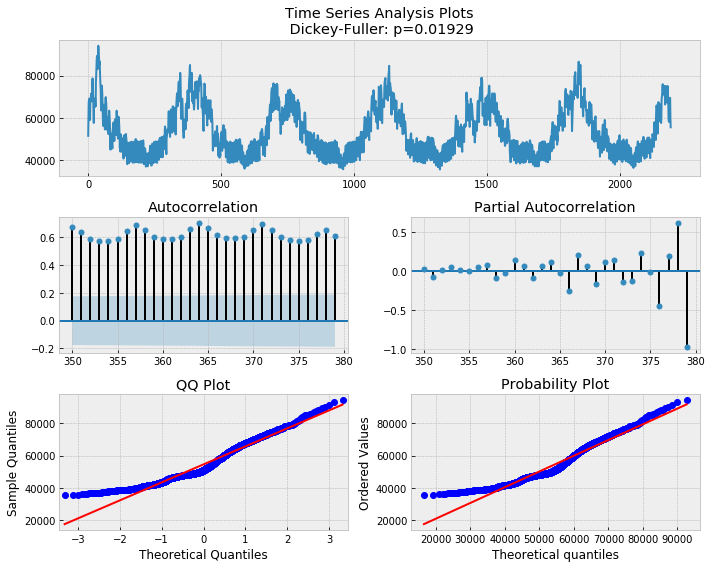

In [57]:
dta=df_p9_first_correction['Consommation'].dropna()
tsplot(dta,lags=np.arange(350,380,1))

### <font color='red'>Obvious year and week saisonnalities<font>

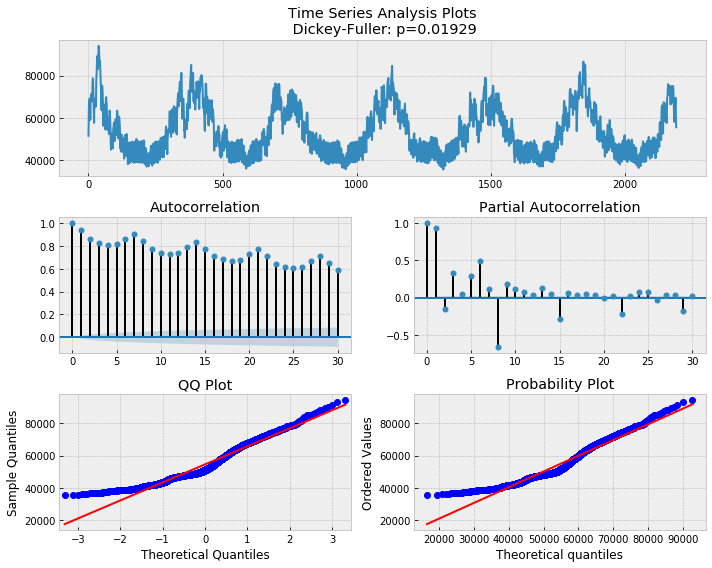

In [58]:
dta=df_p9_first_correction['Consommation'].dropna()
tsplot(dta,lags=30)

### <font color='red'>Day saisonality also, BUT WHAT ABOUT HEAT FIXED?<font>

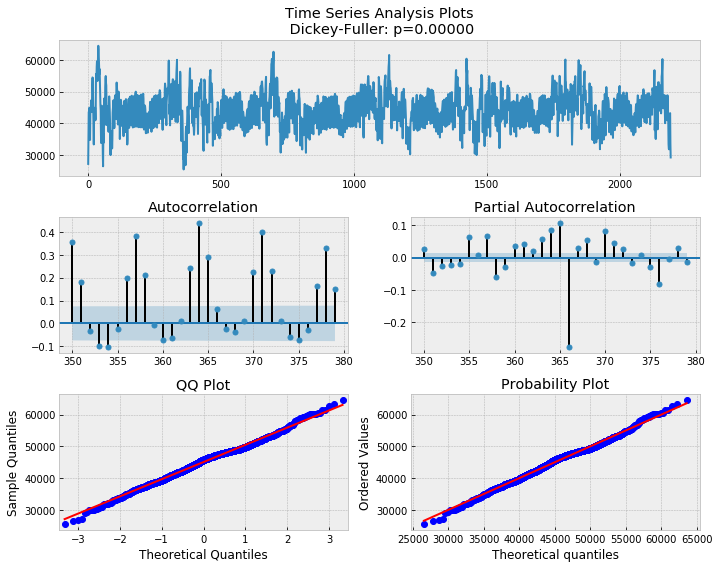

In [59]:
dta=df_p9_first_correction['Correction_consommation'].dropna()
tsplot(dta,lags=np.arange(350,380,1))

### <font color='red'>Week saisonnality remains (ligther but still will need to be incorporated), the year saisonality is pretty well smoothed (366 partial autocoloration is ~ -0.25)<font>

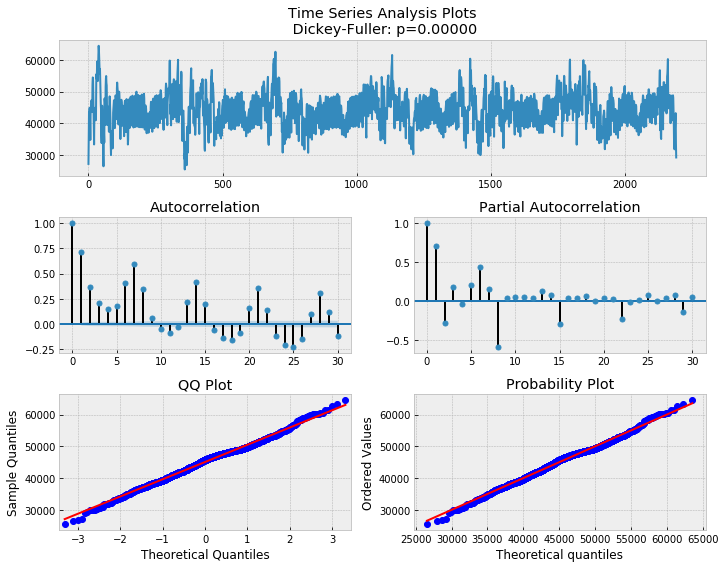

In [60]:
dta=df_p9_first_correction['Correction_consommation'].dropna()
tsplot(dta,lags=30)

### <font color='red'>Week saisonnality (as see right before) BUT A DAY SAISONALITY REMAINS TOO<font>

#### Problématique: en réalité je me suis beaucoup éloigné des données en aggrégeant. La précision exigée au départ (15 ou 30 mins) vole en éclat. 
#### <font color='green'>C'est pourquoi il y a un autre projet dans le dossier, à une échelle horaire<font>

# <font color='orange'>Simple smoothing: Moving Average correction  
#### <font color='green'>Weakness: does not consider the trend => suppose it stable during the period.  
#### <font color='green'>It seems to be the case here.<font>

In [61]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    rolling_mean = series.rolling(window=n).mean()
    return rolling_mean

In [62]:
np.std?

In [63]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()#serie of windows average:  [x-window,---,x-1,x] // window

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {} day(s)".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    """
    
    """
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values",alpha=0.3)
    plt.legend(loc="upper left")
    plt.grid(True)

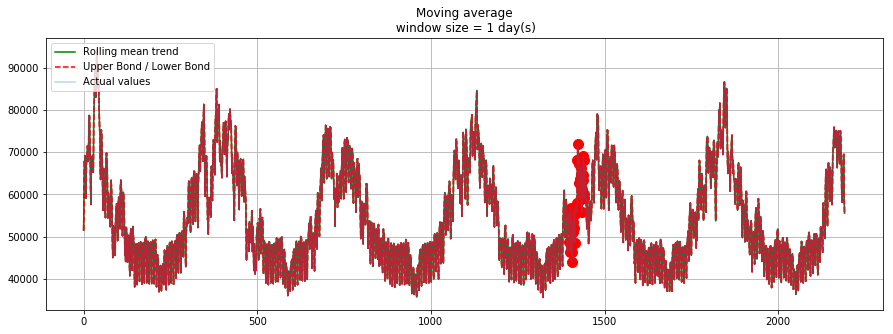

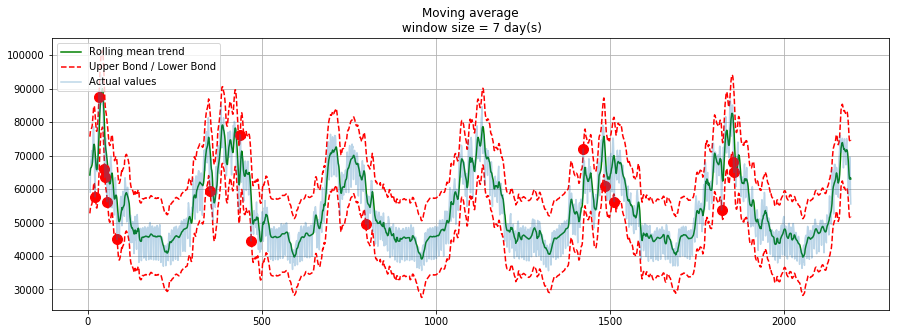

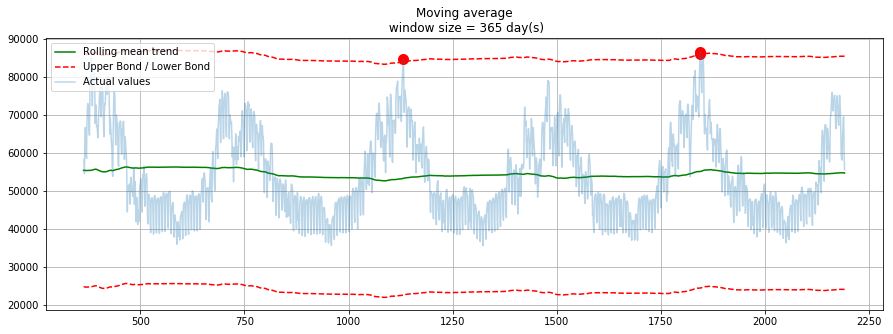

In [64]:
data=df_p9_first_correction.copy()
for i in [1,7,365]:    
    plotMovingAverage(data[['Consommation']], i, plot_intervals=True, plot_anomalies=True)

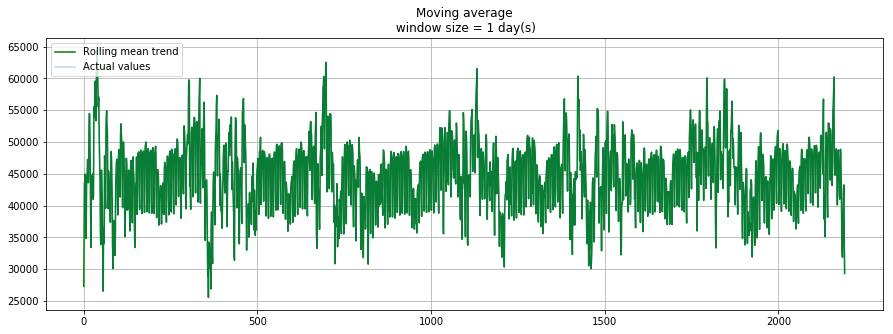

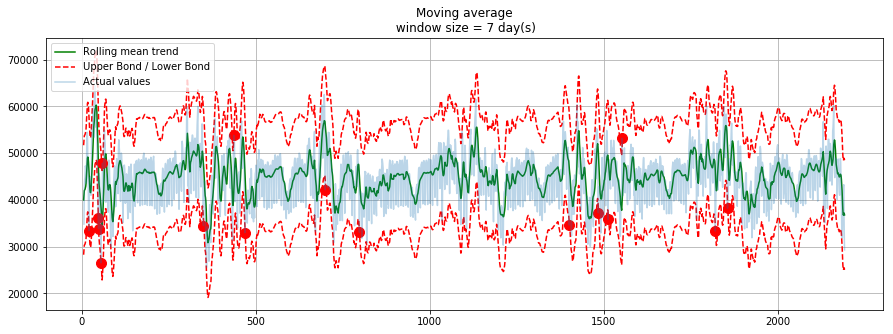

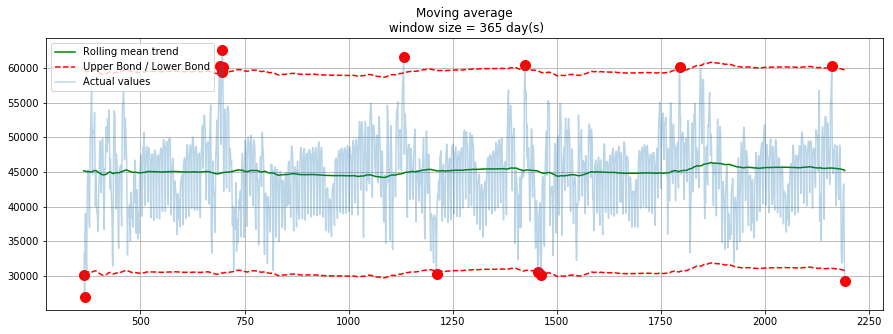

In [65]:
#heat fixed values
data=df_p9_first_correction.copy()
for i in [1,7,365]:
    if i ==1:
        plotMovingAverage(data[['Correction_consommation']], i, plot_intervals=False, plot_anomalies=True)
    else:
        plotMovingAverage(data[['Correction_consommation']], i, plot_intervals=True, plot_anomalies=True)

### <font color='blue'> 365 days rolling smoothing is interessing about extracting the trend. But the bonds (confindence interval) are unaccurated. So it's not proper for forecasting our time series. As expected, Anomalies has been fixed by heat correction.  
### <font color='blue'> 7 days rolling shows some good stuffs but many anomalies.
### <font color='blue'>What about multi rolling average?<font>  
### <font color='blue'>And as we could imagine, 1 day rolling average is naive<font>

In [66]:
### Comparison 365 rolling
data=df_p9_first_correction.copy()
print(len(data))

x=data['Date']
y1=moving_average(data['Correction_consommation'],365)
y2=data['Correction_consommation']


trace1 = go.Line(x=x,
                  y=y1,
                  opacity = 1,
                  name='365 rolling',
                  marker=dict(color='green'))

trace2 = go.Line(x=x,
                  y=y2,
                  opacity = 0.5,
                  name='No rolling',
                  marker=dict(color='red'))

data = [trace1,trace2]

layout = go.Layout(title=dict(text="<b>Consommation corrigée de l'effet de température<b>",
                              font=dict(family='Linux Biolinum O',size=18,color='black')),
                   yaxis=dict(title='KW/h'),
                   xaxis=dict(title='Datum',
                        rangeselector=dict(
                            buttons=list([
                                dict(count=3,
                                     label='1h',
                                     step='hour',
                                     stepmode='backward'),
                                dict(count=3,
                                     label='1d',
                                     step='day',
                                     stepmode='backward'),
                                dict(step='all')
                            ])
                        ),
                        rangeslider=dict(
                            visible = True
                        ),
                        type='date'
    ))



fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)



2192


/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### <font color='green'><font>

### <font color='blue'>What about multi rolling average?<font>  

In [67]:
df_p9_first_correction.loc[:,'co_and_365roll']=moving_average(df_p9_first_correction.loc[:,'Correction_consommation'],365)
df_p9_first_correction.loc[:,'365roll']=moving_average(df_p9_first_correction.loc[:,'Consommation'],365)

### In a stationary time series, statistical properties : constant mean, variance and autocorrelation over time. In a  non-stationary series, these properties are dependent on time: whatever the period of analysis, the behavior of the series remains the same. Time has no more impact.
### In a Stationary time series, there is no visible trend

In [68]:
#Augmented Dickey Fuller test
'''

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root,
with the alternative that there is no unit root (Unit roots are a cause for non-stationarity). If the pvalue is above a critical size (),
then we cannot reject that there is a unit root.

'''
test_pvalue=sm.tsa.stattools.adfuller(x=df_p9_first_correction.co_and_365roll.dropna(), maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[1]
sm.tsa.stattools.adfuller(x=df_p9_first_correction.co_and_365roll.dropna(), maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-2.1460289186433616,
 0.2264132135914052,
 25,
 1802,
 {'1%': -3.4339840952648695,
  '5%': -2.8631452508003057,
  '10%': -2.567624583142913},
 12171.053542697278)

In [69]:
if test_pvalue > .05:
    print('Dickey Fuller test p_value is significant: we cannot reject that there is a unit root => not stationarity serie')
elif test_pvalue < .05:
    print('Dickey Fuller test p_value is significant: we can reject that there is a unit roo => stationarity serie')

Dickey Fuller test p_value is significant: we cannot reject that there is a unit root => not stationarity serie


#### <font color='blue'>L'autocorrélation mesure la corrélation de la série avec elle-même, décalée d'un lag de k périodes<font>
#### <font color='blue'>Lautocorrélation  partielle  mesure  la  corrélation  entre  yt  et  yt-k, l’influence des autres variables (yt-1, yt-2,...,yt-k+1) ayant été retirée<font>

In [70]:
dta=df_p9_first_correction['co_and_365roll'].dropna()
dta.min()

44183.44677078793

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



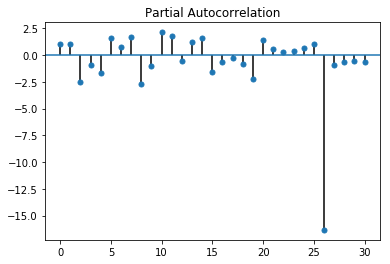

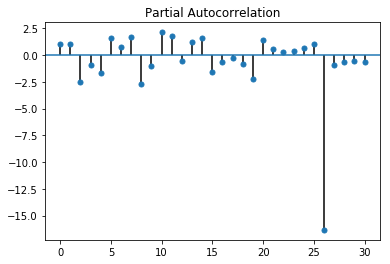

In [71]:
sm.graphics.tsa.plot_pacf(dta, lags=30, alpha=0.5)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



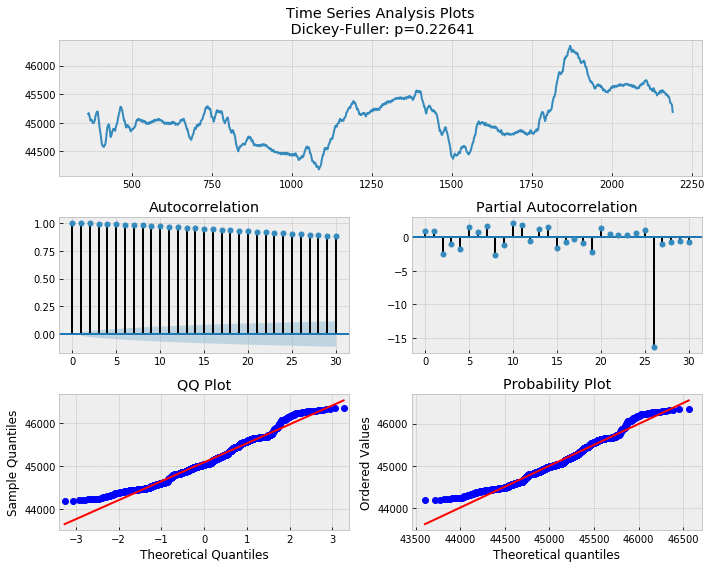

In [72]:
dta=df_p9_first_correction['co_and_365roll'].dropna()
tsplot(dta,lags=30)

In [73]:
df_p9_first_correction.loc[:,'co_and365roll_and7roll']=moving_average(df_p9_first_correction.loc[:,'co_and_365roll'],7)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



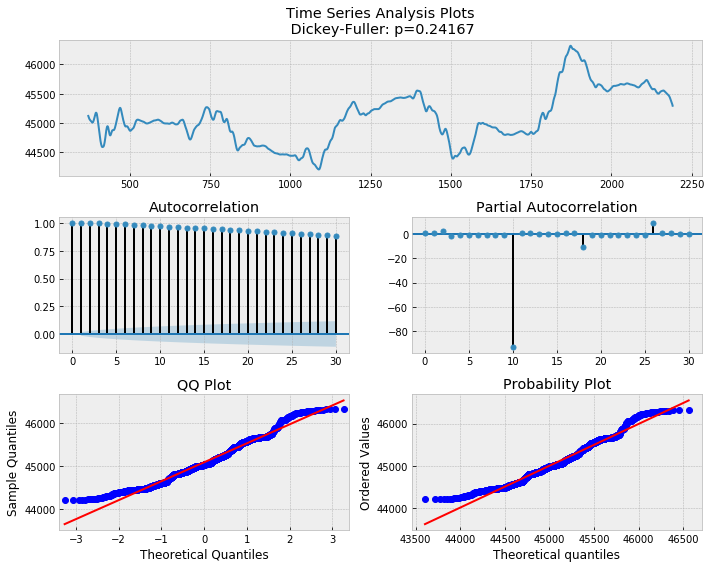

In [74]:
#fixed values and double rolling 365 then 7
dta=df_p9_first_correction['co_and365roll_and7roll'].dropna()
tsplot(dta,lags=30)

Pouquoi désaisonaliser?  
**Analyse simple d'une série temporelle: comparaison de périodes analogues(température des étés de différentes années) pour établir un bilan charactérisant cette période (semaine46) indépendamment de la tendance globale (semaines1,2,3,..52) et des autres tendances(semaines1,2,...,45,47,..52).  
Analyse désaisonnalisée d'une série temporelle: comparaison dynamique/continue d'une période (semaine46 =>semaine, trimestre, mois, heure,...) pour établir un bilan de sa tendance "de fond".**

Lorsque les facteurs saisonniers sont très présents dans une série, le preneur de décision tentera intuitive-ment d’en faire abstraction et de jauger plutôt sa situation sur l’ensemble de ses résultats, sans tenir compte du fait qu’une hausse ou une baisse survient de façon régulière à un moment de l’année.
Retirer les changement brutaux intervenant constamment durant une période constante, pour en extraire la donnée la plus brute/génrale/primaire possible. Et ainsi permettre l'analyse de ses charactéristiques de fond/primaires/... .


Résidus: composante résultant d’erreurs statistiques ou encore d’événements accidentels ou fortuits que l’on sait ne pas avoir de caractère répétitif. Donc, cette composante existe dans la série originale, elle y est observable, mais elle continue d'exister.

Ce qu'on appelle le bruit, ce serait pas cette données brute, parfaitement désaisonnalisée et donc une sorte de "tendance pure" de la série originale? Que(estce que le "cycle" d'une série temporelle?

 to smooth the original time series for spotting trend. As we'll soon see, the wider the window, the smoother the trend.

### <font color='red'>Simple moving average still release some anomalies and series is not stationary<font>

## <font color='orange'>Time serie decomposition<font>  
Main idear is to decompose the serie and extract the trend, the seasonality and the residuals.

In [75]:
rec_year=int(365)

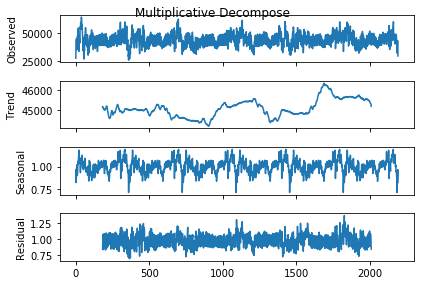

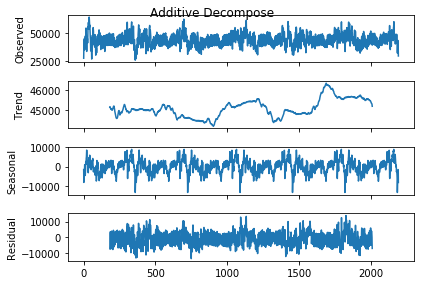

In [76]:
#to see
# Multiplicative Decomposition 
result_mul = seasonal_decompose(x=df_p9_first_correction['Correction_consommation'], freq=rec_year,model='multiplicative')

# Additive Decomposition
result_add = seasonal_decompose(x=df_p9_first_correction['Correction_consommation'], freq=rec_year,model='additive')

# Plot

result_mul.plot().suptitle('Multiplicative Decompose', fontsize=12)
result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

### <font color='green'>No clear trend but 365days seasonal remains in both add and mul decomposition models<font>

In [77]:
from statsmodels.tsa.api import ARIMA,ARMA,SARIMAX

In [78]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Linux Bolunium'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [79]:
df_p9_first_correction['Datetime']=df_p9_first_correction['Date'].astype('datetime64[ns]')
df_p9_first_correction.set_index(inplace=True,drop=True,keys=['Datetime'])
df_p9_first_correction.head(3)

,Date,Consommation,Prevision J-1,Prevision J,Year,Month,Week,Day,Dayofweek,Month_l,dju,Residuals,dju*coeff,Correction_consommation,co_and_365roll,365roll,co_and365roll_and7roll
Datetime,,,,,,,,,,,,,,,,,
2012-01-01,2012-01-01,51491.500000,51085.416667,50452.083333,2012.0,1.0,52.0,1.0,6.0,Jan,248.3,-17784.944963,24200.913064,27290.586936,NaN,NaN,NaN
2012-01-02,2012-01-02,60683.645833,60331.250000,59735.416667,2012.0,1.0,1.0,2.0,0.0,Jan,248.3,-8592.799129,24200.913064,36482.732770,NaN,NaN,NaN
2012-01-03,2012-01-03,67762.104167,66137.500000,66587.500000,2012.0,1.0,1.0,3.0,1.0,Jan,248.3,-1514.340796,24200.913064,43561.191103,NaN,NaN,NaN


In [80]:
train_start,train_end= '2012-01-01','2016-12-31'
test_start,test_end = '2017-01-01','2017-12-31'
train = df_p9_first_correction['Correction_consommation'][train_start:train_end].dropna()
test = df_p9_first_correction['Correction_consommation'][test_start:test_end].dropna()

In [81]:
#ADF-test
'''The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root,
with the alternative that there is no unit root.
If the pvalue is above a critical size, then we cannot reject that there is a unit root.'''
for reg in ['c','ct','ctt','nc']:
    res = sm.tsa.adfuller(df_p9_first_correction['Correction_consommation']['2015-01-01':],regression=reg)
    print(reg,'p-value:{}'.format(res[1]))

c p-value:1.0753339237742927e-07
ct p-value:1.475252682062559e-06
ctt p-value:1.0413438202218926e-05
nc p-value:0.413577402963251


In [82]:
#ADF-test
'''The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root,
with the alternative that there is no unit root.
If the pvalue is above a critical size, then we cannot reject that there is a unit root.'''
for reg in ['c','ct','ctt','nc']:
    res = sm.tsa.adfuller(df_p9_first_correction['Correction_consommation']['2015-01-01':].diff().dropna(),regression=reg)
    print(reg,'p-value:{}'.format(res[1]))

c p-value:1.8080050109231139e-12
ct p-value:5.605044745688862e-11
ctt p-value:2.322095474023779e-10
nc p-value:2.590564314306433e-13


In [83]:
###ARMA
resDiff = sm.tsa.arma_order_select_ic(train,max_ar=7, max_ma=7, ic='aic',  trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred f

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred f

ARMA(p,q) = (7, 6) is the best.


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [84]:
p,q=resDiff['aic_min_order']

In [85]:
mod =ARMA(train, (p,1,q)).fit(trend='c')
mod.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARMA Model Results                                
===================================================================================
Dep. Variable:     Correction_consommation   No. Observations:                 1827
Model:                          ARMA(7, 1)   Log Likelihood              -17135.458
Method:                            css-mle   S.D. of innovations           2861.118
Date:                     Thu, 23 May 2019   AIC                          34290.916
Time:                             09:57:38   BIC                          34346.020
Sample:                         01-01-2012   HQIC                         34311.241
                              - 12-31-2016                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          4.505e+04    641.788     70.199      0.000    4.38e+04    4.63e+04
ar.L1.Correction_consommation     0.1905      0.024      8.094      0.000       0.144       0.237
ar.L2.Correction_consommation     0.1698      0.024      7.158      0.000       0.123       0.216
ar.L3.Correction_consommation    -0.0407      0.021     -1.938      0.053      -0.082       0.000
ar.L4.Correction_consommation     0.0207      0.020      1.020      0.308      -0.019       0.060
ar.L5.Correction_consommation    -0.1082      0.020     -5.406      0.000      -0.147      -0.069
ar.L6.Correction_consommation     0.0135      0.020      0.687      0.492      -0.025       0.052
ar.L7.Correction_consommation     0.5812      0.019     30.414      0.000       0.544       0.619
ma.L1.Correction_consommation     0.6819      0.020     33.907      0.000       0.642       0.721
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0379           -0.0000j            1.0379           -0.0000
AR.2            0.7176           -0.7826j            1.0618           -0.1319
AR.3            0.7176           +0.7826j            1.0618            0.1319
AR.4           -0.2327           -1.0707j            1.0957           -0.2841
AR.5           -0.2327           +1.0707j            1.0957            0.2841
AR.6           -1.0155           -0.4399j            1.1067           -0.4349
AR.7           -1.0155           +0.4399j            1.1067            0.4349
MA.1           -1.4665           +0.0000j            1.4665            0.5000
-----------------------------------------------------------------------------
"""

In [86]:
mod =ARMA(train, (p,1,q)).fit(trend='nc')
mod.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARMA Model Results                                
===================================================================================
Dep. Variable:     Correction_consommation   No. Observations:                 1827
Model:                          ARMA(7, 1)   Log Likelihood              -17154.152
Method:                            css-mle   S.D. of innovations           2886.767
Date:                     Thu, 23 May 2019   AIC                          34326.305
Time:                             09:57:40   BIC                          34375.898
Sample:                         01-01-2012   HQIC                         34344.598
                              - 12-31-2016                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
ar.L1.Correction_consommation     0.2222      0.023      9.708      0.000       0.177       0.267
ar.L2.Correction_consommation     0.1925      0.024      8.093      0.000       0.146       0.239
ar.L3.Correction_consommation    -0.0187      0.021     -0.899      0.369      -0.059       0.022
ar.L4.Correction_consommation     0.0414      0.020      2.053      0.040       0.002       0.081
ar.L5.Correction_consommation    -0.0871      0.020     -4.392      0.000      -0.126      -0.048
ar.L6.Correction_consommation     0.0387      0.019      1.997      0.046       0.001       0.077
ar.L7.Correction_consommation     0.6096      0.019     32.635      0.000       0.573       0.646
ma.L1.Correction_consommation     0.6776      0.020     33.715      0.000       0.638       0.717
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0003           -0.0000j            1.0003           -0.0000
AR.2            0.7146           -0.7828j            1.0599           -0.1322
AR.3            0.7146           +0.7828j            1.0599            0.1322
AR.4           -0.2329           -1.0683j            1.0934           -0.2842
AR.5           -0.2329           +1.0683j            1.0934            0.2842
AR.6           -1.0136           -0.4402j            1.1051           -0.4348
AR.7           -1.0136           +0.4402j            1.1051            0.4348
MA.1           -1.4758           +0.0000j            1.4758            0.5000
-----------------------------------------------------------------------------
"""

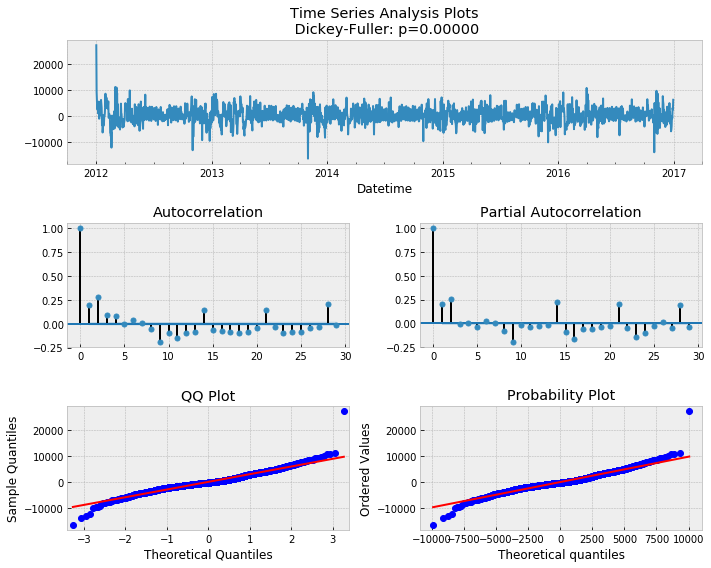

In [87]:
tsplot(mod.resid,lags=np.arange(0,30,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



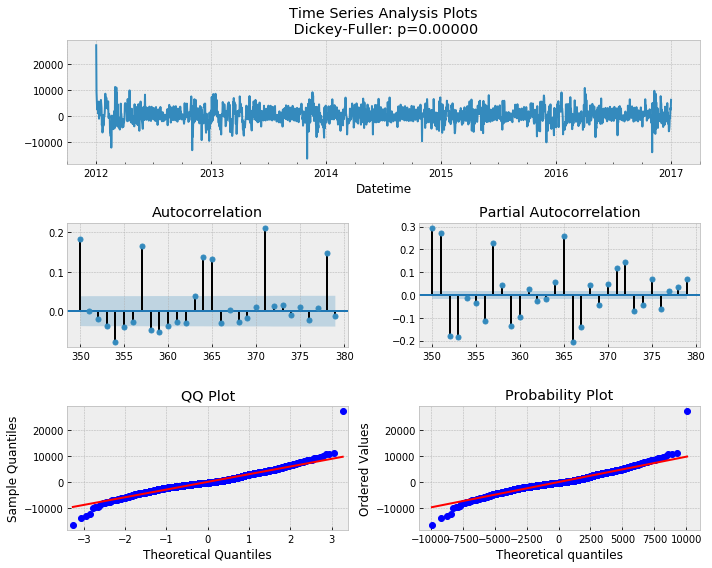

In [88]:
tsplot(mod.resid,lags=np.arange(350,380,1))

### It remans: yea and week seasonalities

## <font color='orange'>SARIMA<font>


    1 for yearly
    4 for quarterly
    12 for monthly
    52 for weekly
    365 for daily


In [89]:
sarima = sm.tsa.statespace.SARIMAX(train,order=(7,1,6),seasonal_order=(7,1,7,1),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:           Correction_consommation   No. Observations:                 1827
Model:             SARIMAX(7, 1, 6)x(7, 1, 7, 1)   Log Likelihood              -16945.595
Date:                           Thu, 23 May 2019   AIC                          33947.191
Time:                                   09:58:18   BIC                          34101.236
Sample:                               01-01-2012   HQIC                         34004.037
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0502      0.637     -3.219      0.001      -3.299      -0.802
ar.L2         -1.3395      0.813     -1.648      0.099      -2.932       0.253
ar.L3          0.4587      0.450      1.020      0.308      -0.423       1.340
ar.L4          1.9202      0.457      4.203      0.000       1.025       2.816
ar.L5          1.9201      0.824      2.331      0.020       0.306       3.535
ar.L6          0.5826      0.667      0.874      0.382      -0.724       1.889
ar.L7         -0.1498      0.248     -0.605      0.545      -0.635       0.335
ma.L1          1.0448      0.190      5.509      0.000       0.673       1.417
ma.L2         -0.6165      0.248     -2.487      0.013      -1.102      -0.131
ma.L3         -0.9807      0.175     -5.596      0.000      -1.324      -0.637
ma.L4         -0.3517      0.210     -1.676      0.094      -0.763       0.060
ma.L5          0.0007      0.171      0.004      0.997      -0.335       0.336
ma.L6          0.0371      0.130      0.285      0.776      -0.218       0.292
ar.S.L1        0.3935      0.643      0.612      0.541      -0.867       1.654
ar.S.L2        0.7433      0.855      0.869      0.385      -0.933       2.420
ar.S.L3       -0.7972      0.443     -1.799      0.072      -1.666       0.071
ar.S.L4       -0.4804      0.323     -1.485      0.137      -1.114       0.153
ar.S.L5        0.5737      0.247      2.320      0.020       0.089       1.058
ar.S.L6        0.4296      0.521      0.825      0.409      -0.591       1.451
ar.S.L7       -0.3873      0.251     -1.545      0.122      -0.879       0.104
ma.S.L1       -0.7963      0.159     -5.006      0.000      -1.108      -0.484
ma.S.L2       -0.6792      0.244     -2.781      0.005      -1.158      -0.201
ma.S.L3        1.1969      0.174      6.865      0.000       0.855       1.539
ma.S.L4        0.1688      0.252      0.670      0.503      -0.325       0.663
ma.S.L5       -1.4034      0.214     -6.569      0.000      -1.822      -0.985
ma.S.L6       -0.1951      0.207     -0.945      0.345      -0.600       0.210
ma.S.L7        0.7083      0.137      5.172      0.000       0.440       0.977
sigma2      6.185e+06   5.06e-07   1.22e+13      0.000    6.19e+06    6.19e+06
===================================================================================
Ljung-Box (Q):                      476.89   Jarque-Bera (JB):              1244.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.92e+29. Standard

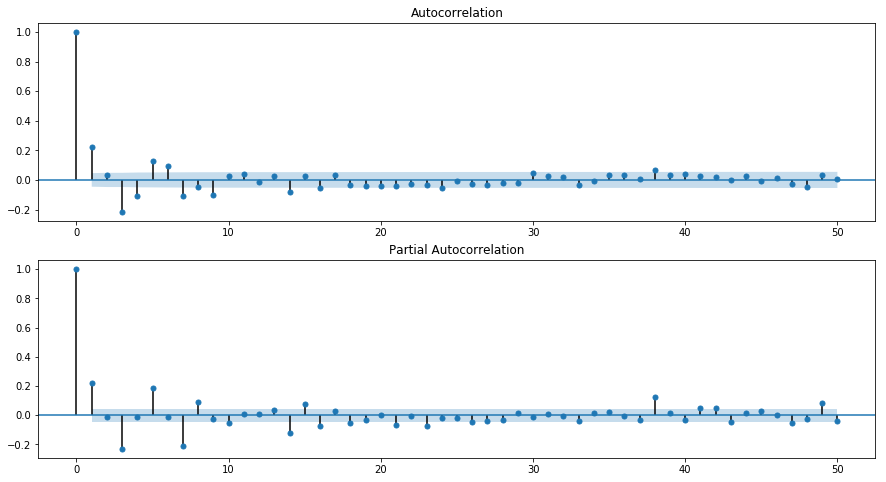

In [90]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [91]:
pred = sarima.predict(train_end,test_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test,pred)))

SARIMA model MSE:33528783992762.418


### <font color='violet'>Seasonality & Trend & Residuals<font>  
Residuals are simply the difference between our predicted value(s) and the observed value(s). Serial correlation is when the residuals (errors) of our TS models are correlated with each other. 

In [92]:
df_p9_first_correction['Residuals']=result_add.resid
df_p9_first_correction['Trend']=result_add.trend
df_p9_first_correction['Seasonal']=result_add.seasonal

df_p9_first_correction['deseasonal'] = df_p9_first_correction['Correction_consommation']-df_p9_first_correction['Seasonal']
df_p9_first_correction['detrend'] = df_p9_first_correction['Correction_consommation']-df_p9_first_correction['Trend']
df_p9_first_correction['deseasonal_detrend'] = df_p9_first_correction['Correction_consommation']-df_p9_first_correction['Seasonal']-df_p9_first_correction['Trend']

In [93]:
data=df_p9_first_correction.copy()
x=data.Datetime
y1=data.Correction_consommation
y2=data.Seasonal
y3=data.Residuals
y4=data.Trend


trace1 = go.Line(x=x,
                  y=y1,
                  name='Correction_consommation',
                  marker=dict(color='red'))

trace2 = go.Line(x=x,
                  y=y2,
                  name='Seasonal',
                  opacity=0.6,
                  marker=dict(color='blue'),
                  yaxis='y2')

trace3 = go.Line(x=x,
                  y=y3,
                  name='Residuals',
                  opacity=1,
                  marker=dict(color='yellow'),
                  yaxis='y2')

trace4 = go.Line(x=x,
                  y=y4,
                  name='Trend',
                  marker=dict(color='green'))


data1 = [trace1,trace2,trace3,trace4]

layout = dict(
    title=dict(text="<b><b>",
               font=dict(family='Linux Biolinum O',size=18,color='black')),
    yaxis2=dict(
                            title='',
                            titlefont=dict(
                                color='rgb(148, 103, 189)'
                            ),
                            tickfont=dict(
                                color='rgb(148, 103, 189)'
                            ),
                            overlaying='y',
                            side='right'
                   ),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=24,
                     label='1d',
                     step='hour',
                     stepmode='backward'),
                dict(count=7,
                     label='1w',
                     step='day',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        )
    )
)


fig = go.Figure(data=data1, layout=layout)

pyo.iplot(fig)


AttributeError: 'DataFrame' object has no attribute 'Datetime'

In [ ]:
data=df_p9_first_correction.copy()

x=data.Datetime

y1=data.Correction_consommation
y2=data.deseasonal
y3=data.detrend
y4=data.deseasonal_detrend

trace1 = go.Line(x=x,
                  y=y1,
                  name='Correction_consommation',
                  marker=dict(color='orange'))


trace2 = go.Line(x=x,
                  y=y2,
                  name='deseasonal',
                  marker=dict(color='green'))

trace3 = go.Line(x=x,
                  y=y3,
                  name='detrend',
                  marker=dict(color='blue'),
                  yaxis='y2')

trace4 = go.Line(x=x,
                  y=y4,
                  name='deseasonal_detrend',
                  marker=dict(color='red'),
                  yaxis='y2')



data1 = [trace1,trace2,trace3,trace4]

layout = dict(
    title=dict(text="<b><b>",
               font=dict(family='Linux Biolinum O',size=18,color='black')),
    yaxis2=dict(
                            title='',
                            titlefont=dict(
                                color='rgb(148, 103, 189)'
                            ),
                            tickfont=dict(
                                color='rgb(148, 103, 189)'
                            ),
                            overlaying='y',
                            side='right'
                   ),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=24,
                     label='1d',
                     step='hour',
                     stepmode='backward'),
                dict(count=7,
                     label='1w',
                     step='day',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        )
    )
)


fig = go.Figure(data=data1, layout=layout)

pyo.iplot(fig)


In [ ]:
df_p9_first_correction.to_csv('data/monthly_fixed_deseasonal_detrend_1.csv', sep=',', encoding='utf-8', index=False)

In [ ]:
df_p9_first_correction = pd.read_csv('./data/monthly_fixed_deseasonal_detrend_1.csv', index_col='Datetime')
df_p9_first_correction.head()

# <font color='Orange'>Exponential smoothing<font>

 instead of only weighting the time series' last k values, we would weight all available observations while exponentially decreasing the weights as we move further back in time.  
 We can think of α as the smoothing factor or memory decay rate, it defines how quickly we will "forget" the last available true observation. The smaller α is, the more influence the previous observations have and the smoother the series is. In other words, the higher the α

, the faster the method "forgets" about the past.



y^x=α⋅yx+(1−α)⋅y^x−1, we can see that in order to make the prediction for y^x we also need to have the observed value yx.

### <font color='violet'>Simple exponential smoothing<font>  AR(p)I(d)MA(q)    (seasonality, trend, and noise)
    (to weight observations by their age)  
Prediction = Prédiction faite à l’instant précédent corrigée par un terme proportionnel à l’erreur de prévision correspondante.  
#### Effective for stationary data points: Irregular data, No seasonality or trend. The initial value to start the smooth have to be determined (the first of the serie, a mean,...).  
If alpha = 1: naive methode: next = previous  
If alpha = 0: mean methode: next = mean(previous)

In [ ]:
def exponential_smoothingzoom(series, alpha, zoom):
    """
        next value is predicted by the previous one, "fixed" by alpha as : x(p) = x(p-1) + alpha*(ap(-1))
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter proportional with the error made at previous prediction
    """
    end=zoom+1
    # first value is same as series
    result = [series[0]]
    end=zoom+1
    for n in range(1, end):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result



def plotExponentialSmoothingzoom(series, alphas, zooms):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):
        for zoom in zooms:
            end=zoom+1

            plt.figure(figsize=(15, 7))
            for alpha in alphas:
                plt.plot(exponential_smoothingzoom(series, alpha,zoom), label="Alpha {}".format(alpha))
            plt.plot(series[:end].values, 'green', alpha=0.4,label = "Actual")
            plt.legend(loc="best")
            plt.axis('tight')
            plt.title("Exponential Smoothing\nfzoom = {} day(s)".format(zoom))
            plt.grid(True);

In [ ]:
data=df_p9_first_correction.reset_index(drop=True)
plotExponentialSmoothingzoom(data.Consommation, [0.2, 0.9],zooms=[1,7,30,365])

In [ ]:
data=df_p9_first_correction.reset_index(drop=True)
plotExponentialSmoothingzoom(data.Correction_consommation, [0.2, 0.9],zooms=[1,7,30,365])

In [ ]:
data=df_p9_first_correction.reset_index(drop=True)
plotExponentialSmoothingzoom(data.co_and_365roll, [0.2, 0.9],zooms=[1,7,30,365])

### <font color='green'>Of course, alpha=0.9 shapes pretty cloth to actual:  <font>
    -high alpha gives more importance to recent data.
    -series has no trend so SES is efficient.
#### the daily seasonality seems caugth by the SMA(0.9): with a step 1, record(x) ~= record(x+1), with hour frequency. In fact, the daily seasonality is probably not caugth

In [ ]:
#finding best alpha:


## <font color='orange'>Double exponential smoothing<font>  
### More efficient for data having trend(s)

if our time series has a trend, we can incorporate that information to do better than just estimating the current level and using that to forecast the future observations. 

In [ ]:
### zoom
def double_exponential_smoothingzoom(series, alpha, beta, zoom):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
        
    end=zoom+1
    # first value is same as series
    result = [series[0]]
    end=zoom+1
    for n in range(1, end):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= end: # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothingzoom(series, alphas, betas, zooms):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    with plt.style.context('seaborn-white'):
        for zoom in zooms:
            end=zoom+1

            plt.figure(figsize=(20, 8))
            for alpha in alphas:
                for beta in betas:
                    plt.plot(double_exponential_smoothingzoom(series, alpha, beta, zoom), label="Alpha {}, beta {}".format(alpha, beta))
            plt.plot(series[:end].values, label = "Actual")
            plt.legend(loc="best")
            plt.axis('tight')
            plt.title("Double Exponential Smoothing\nzoom = {} day(s)".format(zoom))
            plt.grid(True)

In [ ]:
data=df_p9_first_correction.reset_index(drop=True)
plotDoubleExponentialSmoothingzoom(data.Correction_consommation,alphas=[0.9, 0.02], betas=[0.9, 0.02],zooms=[365,30,1])

In [ ]:
data=df_p9_first_correction.reset_index(drop=True)
plotDoubleExponentialSmoothingzoom(data.co_and_365roll,alphas=[0.9, 0.02], betas=[0.9, 0.02],zooms=[1,7,30,365])

Although this method can now predictive future values, if we stare closer at the forecast formula y^x+1=ℓx+kTx, we can see that once the trend (T) is estimated to be positive, all future predictions can only go up from the last value in the time series. On the other hand, if the trend (T) is estimated to be negative, all future predictions can only go down. This property makes this method unsuitable for predicting very far out into the future as well. With that in mind, let's now turn towards triple exponential smoothing.

#### <font color='red'>2 factors exponantial smoothing is interessing. Aspecialy with:  <font>
#### <font color='blue'>-high alpha and high beta (blue)<font>  
#### <font color='orange'>-high alpha and low beta (orange)<font>

### <font color='violet'>Tuning double exponential smoothing<font>
#### Alpha and Beta need to be tuned.  
#### *Alpha smooths the serie around the trend,  
#### *Beta smooth the trend itself.  
      
#### The higher they are, the more weight the most recent observations will have,     
#### and the less smoothed the serie extracted from the model will be.  
  
#### This tune will be done automaticaly (by refering to an accuracy rating (loss function) as MSE, SSE, etc...).

## <font color='orange'>Triple exponential smoothing a.k.a. Holt-Winters<font>  
    Main idear: add seasonal component to our model.  
#### Suitable for univariate time series with trend and/or seasonal components. 
#### We saw earlier that series as many seasonabilities.  
    Then the seasonal component of the 3rd point into the season would be exponentially smoothed with the 3rd point of last season, 3rd point two seasons ago, etc.

https://annals-csis.org/proceedings/2012/pliks/118.pdf

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season -- seasonality
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon -- refering to the time series periodicity
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen#season length
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        """Common method to initiate the trend: the trend averages across seasons"""
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []#ante prediction values smoothed and predictions
        self.Smooth = []#all values smoothed
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization: it can't be predict and first observation of time series is used 
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting session begins
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:#calculated deviation for each value in the time serie beween first value of the serie and prediction start
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
            #confindence boundary          
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

#### <font color='green'>Cross validation to estimate best parameters value<font>
### NEED TO TAKE CARE ABOUT TIME LOGICAL so previous questions are:  
    Length of the duration model will begin to train on?  
    Length of prediction step?  
####    Note that next fold of the cross validation will train on data first train + prediction

In [ ]:

'''TimeSeriesSplit is very interessing for time series:
training fold1 has x values,
trainging fold2 has fold1 values + next x values
.
.
.
testing fold1 has the next x values from traing fold 1
testing fold2 has the next x values from traing fold 2
.
.
.
HOWEVER: n_folds can be limited'''

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=365):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
     # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=2) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
#%%time

data=df_p9_first_correction.Correction_consommation.copy()

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function => optimizing algo
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method='TNC', bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the 30 next freq
model = HoltWinters(series=data, slen=365,
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, 
                    scaling_factor = 1)
model.triple_exponential_smoothing()

In [ ]:
def plotHoltWinters(series, slen, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, '-',label = "Model",linewidth=3, color='orange')
    plt.plot(series.values, label = "Data",color='green')
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=.8, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=.8)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=1, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-12, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
plotHoltWinters(series=model.series, plot_intervals=False, plot_anomalies=False, slen=365)

In [ ]:
def plotHoltWinters_zoom(series, zoom):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    r = randint(a=zoom/2,b=len(series)-zoom/2)
    r1 =int(r-zoom/2)
    r2=int(r+zoom/2)
    x=list(np.arange(0,zoom))
    model.series.index[r1:r2]
    res=model.result[r1:r2]
    val=list(model.series.values[r1:r2])
    start=model.series.index[r1]
    end=model.series.index[2]
    
    plt.figure(figsize=(20, 10))
    plt.plot(res, label = "Model")
    plt.plot(val, label = "Data")
    error = mean_absolute_percentage_error(np.array(val), res)
    plt.title("Mean Absolute Percentage Error: {:.2f}%\nRandom periode : {} to {}".format(error,start,end))
    plt.legend(loc="best", fontsize=13);

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## <font color='orange'>SARIMA: Seasonal Auto Regressive Integrated Moving Average<font>  
Exponential smoothings methods are appropriate for non-stationary data (data with a trend and seasonal data). But we don't find a trend here.

In [ ]:
mod = sm.tsa.SARIMAX(data.Correction_consommation,order = (3,1,0), seasonal_order=(0,0,0,12)).fit()
mod.summary()

In [ ]:
mod.plot_diagnostics(figsize=(12,6))

In [ ]:
#AdFuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(data.Correction_consommation, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

In [ ]:
mod = sm.tsa.SARIMAX(recent,order = (3,1,0), seasonal_order=(0,0,0,12)).fit()
mod.summary()

In [ ]:
x = data['Date']
y = data['Consommation'].reset_index(drop=True)

mod = sm.tsa.statespace.SARIMAX(y, trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

In [ ]:
res = sm.tsa.seasonal_decompose(y,freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()